There is a lot more that you can do with outputs (such as including interactive outputs)
with your book. For more information about this, see [the Jupyter Book documentation](https://jupyterbook.org)


# Обработка информации об уязвимостях полученных из CVE Project (https://github.com/CVEProject/cvelistV5)


In [21]:
from concurrent.futures import ThreadPoolExecutor
import httpx
import zipfile
import tempfile
from pathlib import Path
import orjson as ojson
from typing import Any
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from const import CVE_PROJECT_CVES_DATA_PATH

## Скачивание данных


In [18]:
CVE_ZIP_URL = "https://github.com/CVEProject/cvelistV5/releases/download/cve_2024-01-05_1500Z/2024-01-05_all_CVEs_at_midnight.zip.zip"
# Download archive
resp = httpx.get(CVE_ZIP_URL, follow_redirects=True)

with tempfile.TemporaryDirectory() as tmpdir:
    tmp_path = Path(tmpdir)

    with (tmp_path / "cve.zip.zip").open("wb") as f:
        f.write(resp.content)

    with zipfile.ZipFile(f.name, "r") as zip_ref:
        tmp_zip = tmp_path / "cves.zip"
        zip_ref.extractall(tmp_path)
        with zipfile.ZipFile(tmp_zip) as zip_ref:
            files_to_extract = [
                name
                for name in zip_ref.namelist()
                if name.startswith(tuple(f"cves/{year}/" for year in range(2013, 2023)))
            ]
            zip_ref.extractall(members=files_to_extract)

In [2]:
cves_data: list[dict[str, Any]] = []
cves_folder = Path("cves/")
with ThreadPoolExecutor(20) as p:
    filename: str
    for filename, content in p.map(lambda fp: (fp.name, fp.read_text()), cves_folder.rglob("*.json")):
        data = ojson.loads(content)
        data["cve_id"] = filename[4:-5]
        data["year"] = filename[4:-9]
        cves_data.append(data)

len(cves_data)

175031

In [5]:
CWE_ZIP_URL = "https://cwe.mitre.org/data/csv/1000.csv.zip"
# Download archive
resp = httpx.get(CWE_ZIP_URL, follow_redirects=True)

with tempfile.TemporaryDirectory() as tmpdir:
    tmp_path = Path(tmpdir)

    with (tmp_path / "cwe.zip").open("wb") as f:
        f.write(resp.content)

    with zipfile.ZipFile(f.name, "r") as zip_ref:
        cwes_folder = Path("cwes/")
        cwes_folder.mkdir(exist_ok=True)
        zip_ref.extractall(cwes_folder)

In [3]:
cwes = pl.read_csv("cwes/1000.csv", truncate_ragged_lines=True)
cwes.describe()

describe,CWE-ID,Name,Weakness Abstraction,Status,Description,Extended Description,Related Weaknesses,Weakness Ordinalities,Applicable Platforms,Background Details,Alternate Terms,Modes Of Introduction,Exploitation Factors,Likelihood of Exploit,Common Consequences,Detection Methods,Potential Mitigations,Observed Examples,Functional Areas,Affected Resources,Taxonomy Mappings,Related Attack Patterns,Notes
str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""count""",934.0,"""934""","""934""","""934""","""934""","""934""","""934""","""934""","""934""","""934""","""934""","""934""","""934""","""934""","""934""","""934""","""934""","""934""","""934""","""934""","""934""","""934""","""934"""
"""null_count""",0.0,"""0""","""0""","""0""","""0""","""0""","""9""","""0""","""213""","""0""","""0""","""0""","""0""","""934""","""0""","""0""","""0""","""0""","""902""","""883""","""0""","""598""","""0"""
"""mean""",612.599572,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""std""",404.050165,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""min""",5.0,""".NET Misconfig…","""Base""","""Draft""","""A J2EE applica…","""""","""::NATURE:CanPr…","""""","""::ARCHITECTURE…","""""","""""","""""","""""",null,"""""","""""","""""","""""","""::Authenticati…","""::CPU::""","""""","""::100::""",""""""
"""25%""",273.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""50%""",551.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""75%""",941.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""max""",1419.0,"""finalize() Met…","""Variant""","""Stable""","""[PLANNED FOR D…","""XML documents …","""::NATURE:Start…","""::ORDINALITY:R…","""::TECHNOLOGY N…","""::Windows prov…","""::TERM:tabnabb…","""::PHASE:Testin…","""""",null,"""::SCOPE:Other:…","""::METHOD:White…","""::PHASE:Testin…","""::REFERENCE:CV…","""::Signals::Int…","""::System Proce…","""::TAXONOMY NAM…","""::97::""","""::TYPE:Theoret…"


## Обработка CWE типов


In [4]:
# Get only cves with cwe
cves_with_cwe_data: list[dict[str, Any]] = []
for cve_data in cves_data:
    problem_types = cve_data["containers"]["cna"].get("problemTypes")
    if problem_types:
        cves_with_cwe_data.append(cve_data)

len(cves_with_cwe_data)

160649

## Обработка данных

In [13]:
vulnerabilities_data: list[dict[str, str | float | None]] = []
for cve in cves_data:
    has_cwe = False
    for problem_type in cve["containers"]["cna"].get("problemTypes", []):
        for cwe_description in problem_type["descriptions"]:
            if cwe_description.get("cweId"):
                score = None
                has_cwe = True
                if metrics := cve["containers"]["cna"].get("metrics"):
                    for metric in metrics:
                        if "cvssV3_1" in metric:
                            score = float(metric["cvssV3_1"]["baseScore"])
                        if "cvssV3_0" in metric and score is None:
                            score = float(metric["cvssV3_0"]["baseScore"])

                vulnerabilities_data.append(
                    {
                        "cve_id": cve["cve_id"],
                        "cwe_id": cwe_description["cweId"],
                        "score": score,
                    }
                )
    if not has_cwe:
        vulnerabilities_data.append(
            {
                "cve_id": cve["cve_id"],
                "cwe_id": None,
                "score": None,
            }
        )
vulnerabilities: pl.DataFrame = pl.from_dicts(
    vulnerabilities_data, schema={"cve_id": str, "cwe_id": str, "score": float}
)
vulnerabilities.describe()

describe,cve_id,cwe_id,score
str,str,str,f64
"""count""","""176206""","""176206""",176206.0
"""null_count""","""0""","""135915""",146653.0
"""mean""",null,null,6.5841
"""std""",null,null,1.799266
"""min""","""2013-0001""","""CWE-1004""",0.0
"""25%""",null,null,5.4
"""50%""",null,null,6.5
"""75%""",null,null,7.8
"""max""","""2023-6622""","""CWE-99""",10.0


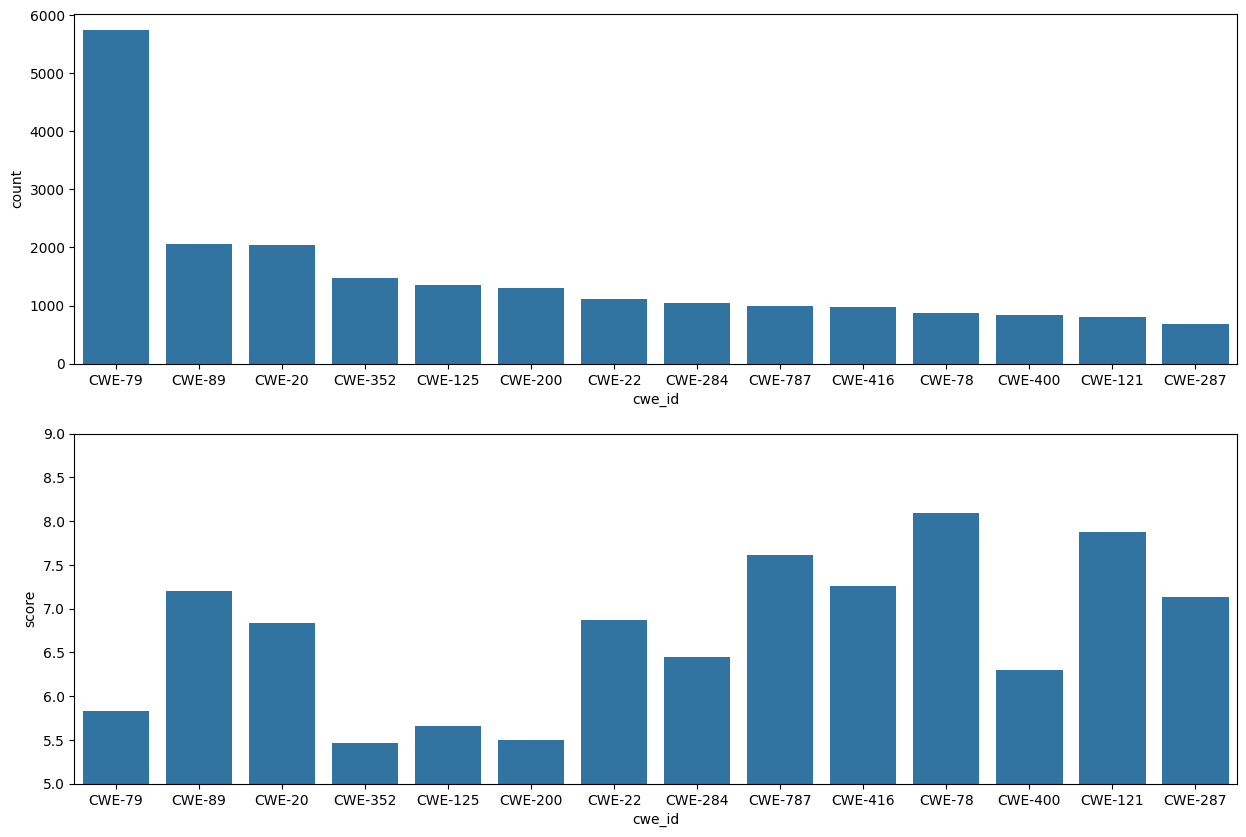

In [14]:
fig, ax = plt.subplots(2, figsize=(15, 10))
top_vulnerabilities = vulnerabilities.group_by("cwe_id").count().sort("count", descending=True).limit(15)
top_ids = top_vulnerabilities.select("cwe_id").to_series().to_list()
ax[1].set_ylim(5, 9)
sns.barplot(top_vulnerabilities, x="cwe_id", y="count", ax=ax[0])
sns.barplot(
    top_vulnerabilities.select("cwe_id").join(
        vulnerabilities.filter(pl.col("cwe_id").is_in(top_ids)).group_by("cwe_id").mean(), on="cwe_id", how="left"
    ),
    x="cwe_id",
    y="score",
    ax=ax[1],
)
plt.show()

In [15]:
with pl.Config(fmt_str_lengths=200, tbl_width_chars=150, tbl_rows=20):
    print(
        top_vulnerabilities.select(pl.col("cwe_id").str.slice(4).cast(pl.Int64)).join(
            cwes.rename({"CWE-ID": "cwe_id"}).select(["cwe_id", "Name", "Description"]), on="cwe_id"
        )
    )

shape: (14, 3)
┌────────┬─────────────────────────────────────────────────────────────────────┬─────────────────────────────────────────────────────────────────────┐
│ cwe_id ┆ Name                                                                ┆ Description                                                         │
│ ---    ┆ ---                                                                 ┆ ---                                                                 │
│ i64    ┆ str                                                                 ┆ str                                                                 │
╞════════╪═════════════════════════════════════════════════════════════════════╪═════════════════════════════════════════════════════════════════════╡
│ 20     ┆ Improper Input Validation                                           ┆ The product receives input or data, but it does not validate or     │
│        ┆                                                                     

In [16]:
cve_project_cves: list[dict[str, Any]] = []
filled_affected_count = 0
for cve_data in cves_data:
    # if affected := cve_data["containers"]["cna"].get("affected"):
    #     affected_products: list[str | None] = []
    #     for affected_product in cve_data["containers"]["cna"].get("affected", []):
    #         if "versions" in affected_product:
    #             affected_product.pop("versions")
    #         affected_products.append(affected_product.get("product"))

    references: list[str] = []
    for reference in cve_data["containers"]["cna"].get("references", []):
        if url := reference["url"]:
            references.append(url)
    cve_project_cves.append({"cve_id": cve_data["cve_id"], "reference": references})

# f"Percentage with known CWE: {filled_affected_count * 100 / len(cves_data):.2f}%"

In [22]:
products_cves = pl.DataFrame(cve_project_cves)
products_cves = products_cves.explode("reference")
products_cves = products_cves.join(vulnerabilities.select(["cwe_id", "cve_id"]), on="cve_id", how="left")
products_cves.write_csv(CVE_PROJECT_CVES_DATA_PATH)
products_cves.describe()

describe,cve_id,reference,cwe_id
str,str,str,str
"""count""","""489547""","""489547""","""489547"""
"""null_count""","""0""","""11917""","""400211"""
"""mean""",null,null,null
"""std""",null,null,null
"""min""","""2013-0001""","""ftp://FTP2.DLI…","""CWE-1004"""
"""25%""",null,null,null
"""50%""",null,null,null
"""75%""",null,null,null
"""max""","""2023-6622""","""ttps://www.clo…","""CWE-99"""


In [13]:
cve_project_path = Path("results/cve_project_cves.csv")
github_path = Path("results/github_cves.csv")
github_commit_path = Path("results/github_commit_data.csv")

## Фильтрация проектов без открытого исходного кода

In [1]:
products_to_include: set[str] = set(pl.read_csv("open_source_products.csv").to_series())
filtered_cves: pl.DataFrame = products_cves.filter(pl.col("product").is_in(products_to_include))
f"Open source cves percentage: {filtered_cves.unique('cve_id').shape[0] * 100 / products_cves.unique('cve_id').shape[0]:.2f}%"

NameError: name 'pl' is not defined

In [15]:
Path("results").mkdir(exist_ok=True)
products_cves.head(5)

cve_id,reference,cwe_id
str,str,str
"""2022-2909""","""https://s1.ax1…","""CWE-434"""
"""2022-2909""","""https://vuldb.…","""CWE-434"""
"""2022-2323""","""https://psirt.…","""CWE-77"""
"""2022-2289""","""https://huntr.…","""CWE-416"""
"""2022-2289""","""https://github…","""CWE-416"""
